3media: Facebook, TV, Search

iterations = 1,000  
trials = 3  
calibration_constraint = 0.1  

In [123]:
import os
import json
from glob import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
# Set variables.
dpg_name = "dgp3_1000_3_01_3media"
root_dir = f"/Users/s11616/Desktop/{dpg_name}"

In [125]:
rows = []
for exp_name in os.listdir(root_dir):
    jsonfile_paths = glob(os.path.join(root_dir, exp_name, '*.json'))
    
    for jsonfile_path in jsonfile_paths:
        
        jsonfile_name = jsonfile_path.split('/')[-1]
        if jsonfile_name == 'RobynModel-inputs.json':
            continue
        
        with open(jsonfile_path) as f:
            dic = json.load(f)
        
        for i, vals in enumerate(dic['ExportedModel']['summary']):
            if vals['variable'] in ['(Intercept)', 'trend', 'season', 'holiday'] :
                continue
            
            rows.append([exp_name, jsonfile_name, vals['variable'].split('_')[-1], vals['performance']])

In [126]:
df = pd.DataFrame(rows)
df.columns = ['EXP_NAME', 'FILENAME', 'MEDIA', 'PRED_ROI']

df['DPG'] = dpg_name

In [127]:
df_true = pd.read_csv(os.path.join(root_dir, os.listdir(root_dir)[0], 'true_roi.csv'))

In [128]:
df_true

,x
0,roi of Facebook is: 2.88238320878217
1,roi of TV is: 0.830049784717038
2,roi of Search is: 0.00610569194515542


In [129]:
_df_true = pd.DataFrame({'MEDIA': ['Facebook', 'TV', 'Search'], 'TRUE_ROI': [float(x[0].split(': ')[1]) + 1 for x in df_true.values]})

In [130]:
df = pd.merge(df, _df_true, on='MEDIA')

In [131]:
# Parse EXP_NAME.
df['USE_PROPHET'] = df['EXP_NAME'].apply(lambda x: bool(x.split('_')[1])).astype(int)

df['CALIBRATION_FACEBOOK'] = df['EXP_NAME'].str.contains('Facebook').astype(int)
df['CALIBRATION_TV'] = df['EXP_NAME'].str.contains('TV').astype(int)
df['CALIBRATION_SEARCH'] = df['EXP_NAME'].str.contains('Search').astype(int)

In [156]:
def get_segmentname(row):
    cols = np.array(['Facebook', 'TV', 'Search'])
    flag = np.array([row[f'CALIBRATION_{x.upper()}'] for x in cols])
    if sum(flag) == 0:
        return '0. None'
    else:
        x = sum(np.arange(1, 4) * flag)
        return f'{x}. ' + '_'.join(cols[np.where(flag == 1)])

In [157]:
df['SEGMENT_NAME'] = df.apply(lambda row: get_segmentname(row), axis=1)

In [158]:
df

,EXP_NAME,FILENAME,MEDIA,PRED_ROI,DPG,TRUE_ROI,USE_PROPHET,CALIBRATION_FACEBOOK,CALIBRATION_TV,CALIBRATION_SEARCH,SEGMENT_NAME,APE_ROI
0,prophet_TRUE_calib_,RobynModel-2_18_10.json,Facebook,3.3975,dgp3_1000_3_01_3media,3.882383,1,0,0,0,0. None,0.124893
1,prophet_TRUE_calib_,RobynModel-1_67_11.json,Facebook,3.2980,dgp3_1000_3_01_3media,3.882383,1,0,0,0,0. None,0.150522
2,prophet_TRUE_calib_,RobynModel-1_65_5.json,Facebook,3.0087,dgp3_1000_3_01_3media,3.882383,1,0,0,0,0. None,0.225038
3,prophet_TRUE_calib_,RobynModel-1_62_1.json,Facebook,1.3137,dgp3_1000_3_01_3media,3.882383,1,0,0,0,0. None,0.661625
4,prophet_TRUE_calib_,RobynModel-1_61_13.json,Facebook,1.0402,dgp3_1000_3_01_3media,3.882383,1,0,0,0,0. None,0.732072
...,...,...,...,...,...,...,...,...,...,...,...,...
133,prophet_TRUE_calib_spend_Facebook_spend_TV,RobynModel-1_47_6.json,Search,1.6062,dgp3_1000_3_01_3media,1.006106,1,1,1,0,3. Facebook_TV,0.596453
134,prophet_TRUE_calib_spend_Facebook_spend_TV,RobynModel-1_55_7.json,Search,2.5309,dgp3_1000_3_01_3media,1.006106,1,1,1,0,3. Facebook_TV,1.515541
135,prophet_TRUE_calib_spend_Facebook_spend_TV,RobynModel-1_46_15.json,Search,1.8769,dgp3_1000_3_01_3media,1.006106,1,1,1,0,3. Facebook_TV,0.865510
136,prophet_TRUE_calib_spend_Facebook_spend_TV,RobynModel-1_39_7.json,Search,1.6043,dgp3_1000_3_01_3media,1.006106,1,1,1,0,3. Facebook_TV,0.594564


In [159]:
df[['MEDIA', 'TRUE_ROI']].drop_duplicates()

,MEDIA,TRUE_ROI
0,Facebook,3.882383
46,TV,1.830050
92,Search,1.006106


In [160]:
def ape(pred, true):
    return abs((pred - true) / true)

In [161]:
df['APE_ROI'] = ape(df['PRED_ROI'], df['TRUE_ROI'])

In [162]:
cp = {'Facebook': sns.color_palette()[0], 'TV': sns.color_palette()[1], 'Search': sns.color_palette()[2]}

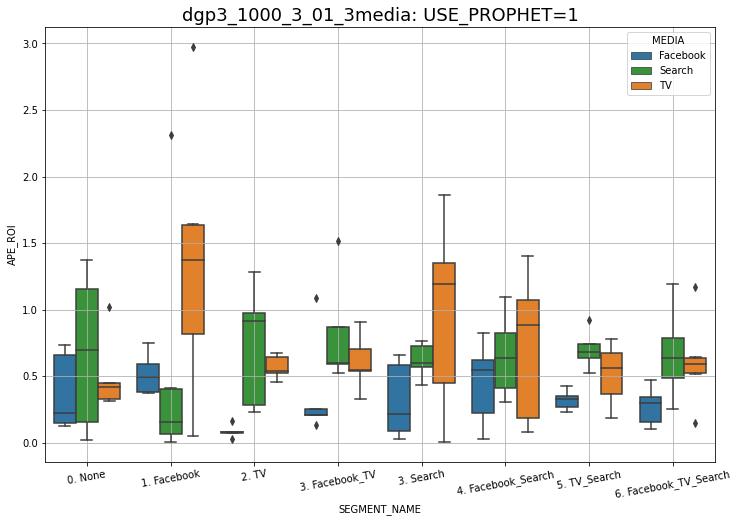

In [165]:
for use_prophet in [1]:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x = "SEGMENT_NAME", y = "APE_ROI", data = df[df['USE_PROPHET'] == use_prophet].sort_values('SEGMENT_NAME'), hue='MEDIA', palette=cp)
    plt.title(f'{dpg_name}: USE_PROPHET={use_prophet}', fontsize=18)
    plt.xticks(rotation=10)
    plt.grid()

In [166]:
df.to_csv(f'{dpg_name}.csv', index=False)